<a href="https://colab.research.google.com/github/nikhilchalis/GANs/blob/main/Single_class_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install torch torchvision matplotlib

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [38]:
class MNISTSubset(Dataset):
    def __init__(self, dataset, target_labels):
        self.dataset = dataset
        self.target_labels = target_labels
        self.filtered_indices = [i for i, (_, label) in enumerate(self.dataset) if label in self.target_labels]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        actual_idx = self.filtered_indices[idx]
        return self.dataset[actual_idx]

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter only digits 0 and 1
target_labels_vec = [5]
filtered_train_dataset = MNISTSubset(train_dataset, target_labels=target_labels_vec)

train_loader = DataLoader(filtered_train_dataset, batch_size=64, shuffle=True)


In [39]:
NOISE_SIZE = 5
NUM_INPUT_CLASSES = 10
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(NUM_INPUT_CLASSES, NOISE_SIZE)  # 10 classes, 10-dim embedding for each class
        self.model = nn.Sequential(
            nn.Linear(NOISE_SIZE*NUM_INPUT_CLASSES + NOISE_SIZE, 256),  # 100 for noise + 10 for class embedding
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 28*28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embeddings = self.embedding(labels)  # Convert labels to embeddings
        x = torch.cat((noise, label_embeddings), dim=1)  # Concatenate noise and label embeddings
        return self.model(x).view(-1, 1, 28, 28)


In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)


In [41]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
lr = 0.001
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)


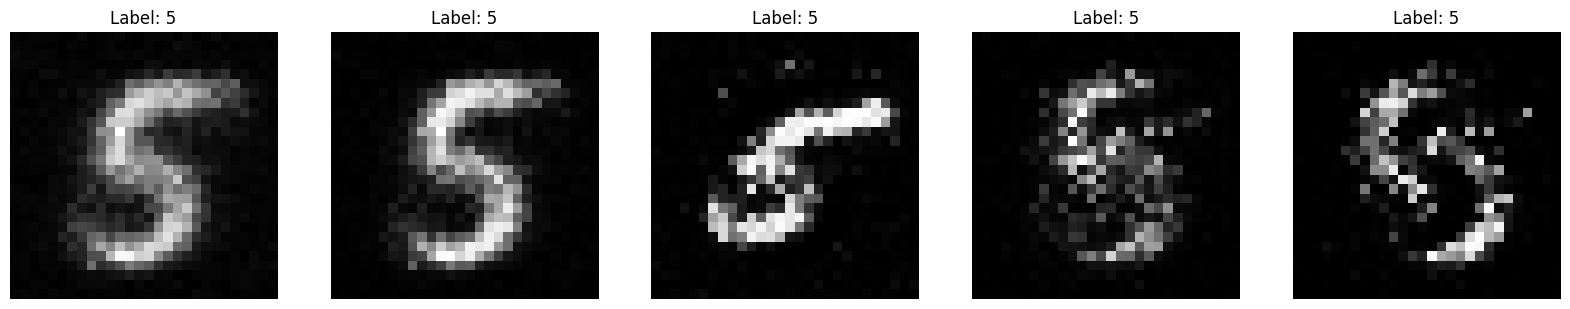

Epoch [1/20], d_loss: 0.5076, g_loss: 2.1245


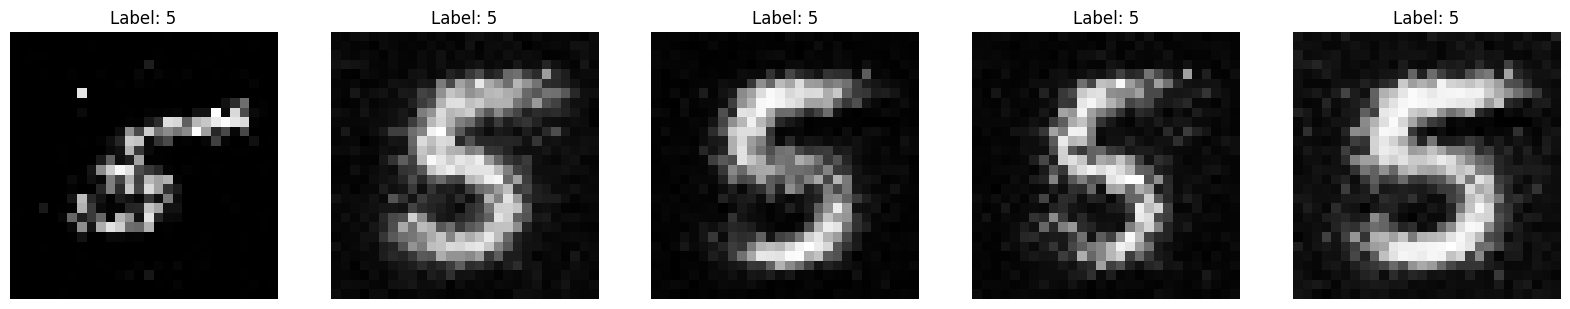

Epoch [2/20], d_loss: 0.6180, g_loss: 2.2778


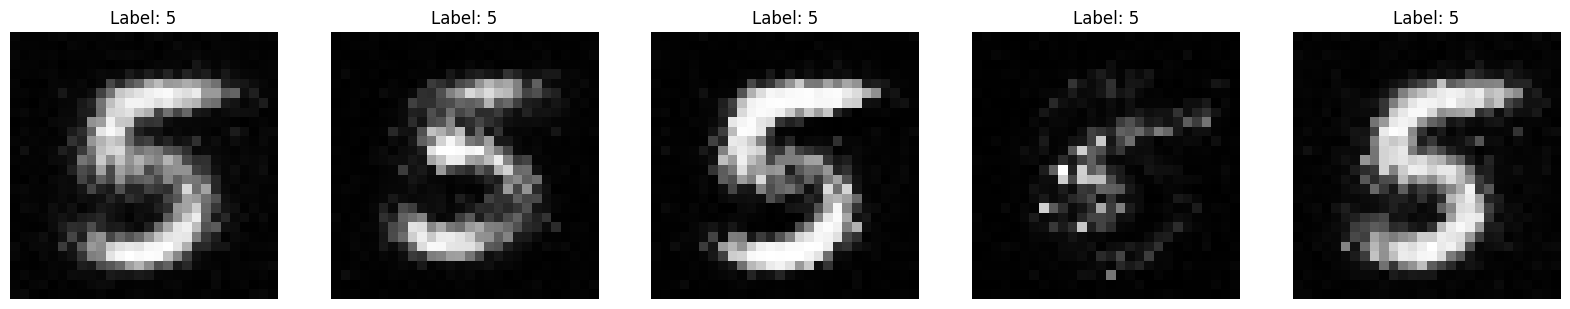

Epoch [3/20], d_loss: 0.8114, g_loss: 1.8260


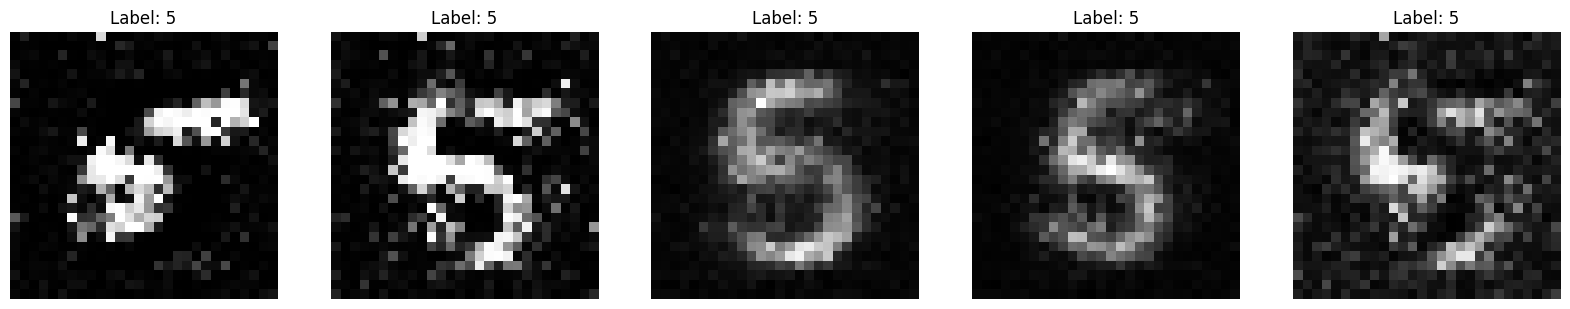

Epoch [4/20], d_loss: 0.5671, g_loss: 2.2824


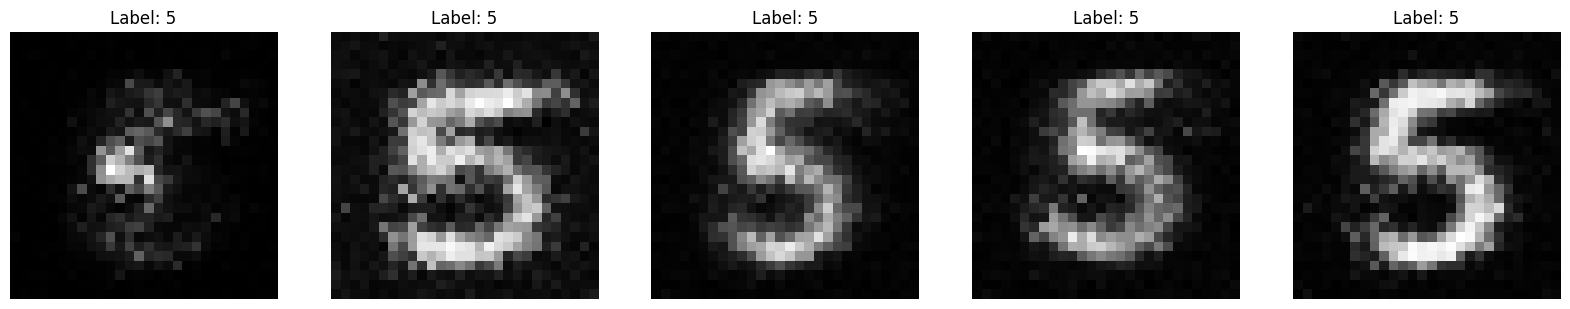

Epoch [5/20], d_loss: 0.6181, g_loss: 2.0299


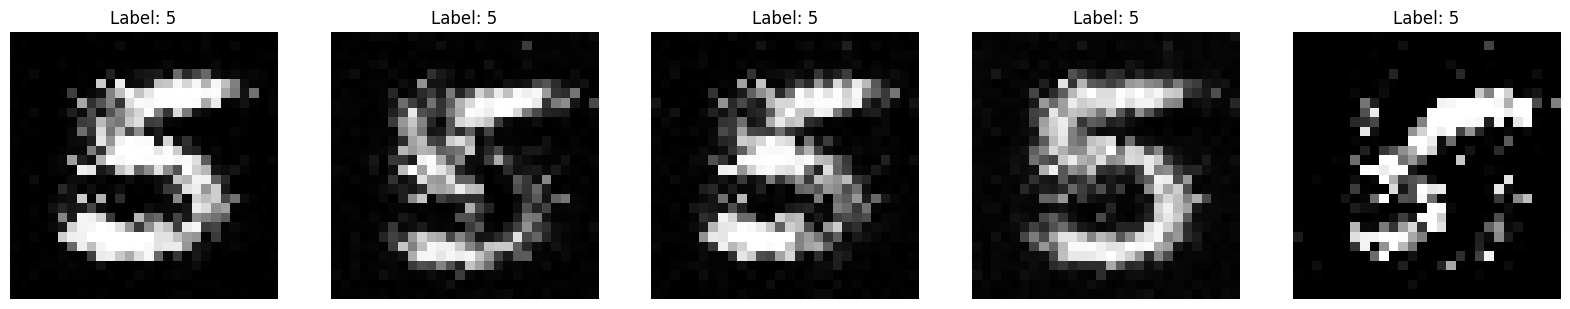

Epoch [6/20], d_loss: 0.5977, g_loss: 2.6957


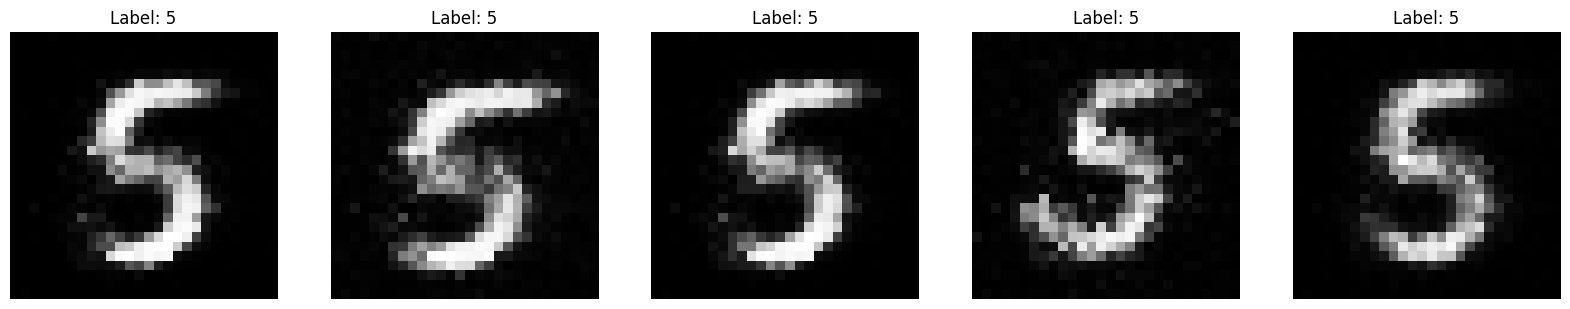

Epoch [7/20], d_loss: 0.8875, g_loss: 1.3663


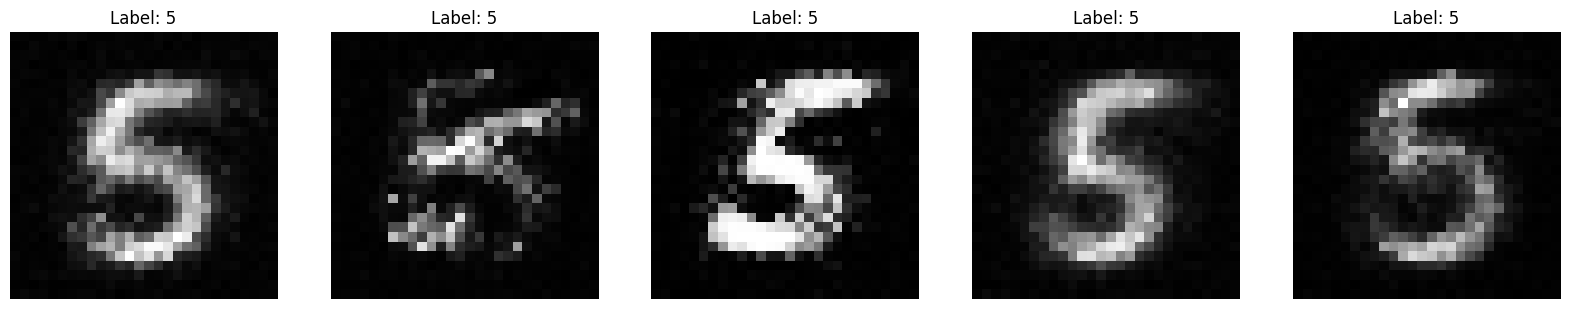

Epoch [8/20], d_loss: 0.8383, g_loss: 1.3889


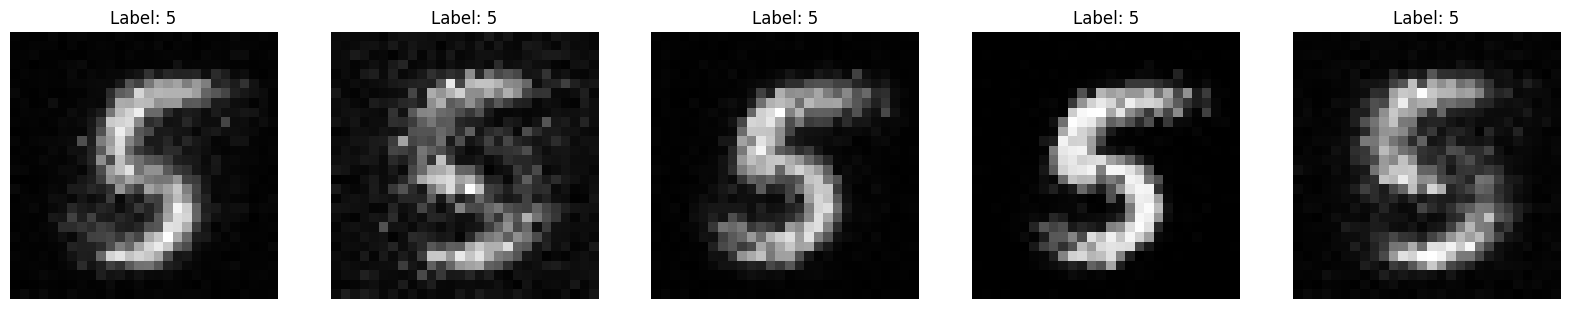

Epoch [9/20], d_loss: 0.8006, g_loss: 1.7671


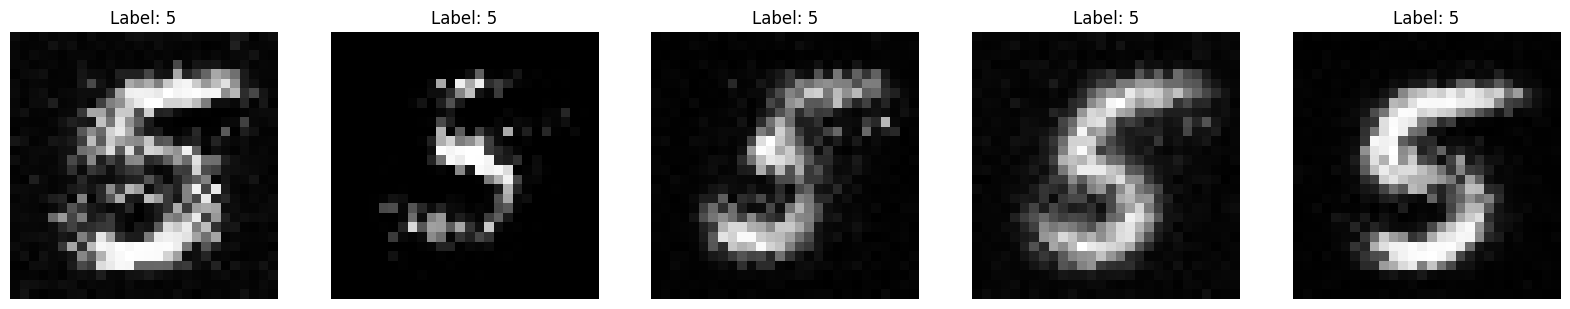

Epoch [10/20], d_loss: 1.1013, g_loss: 1.5806


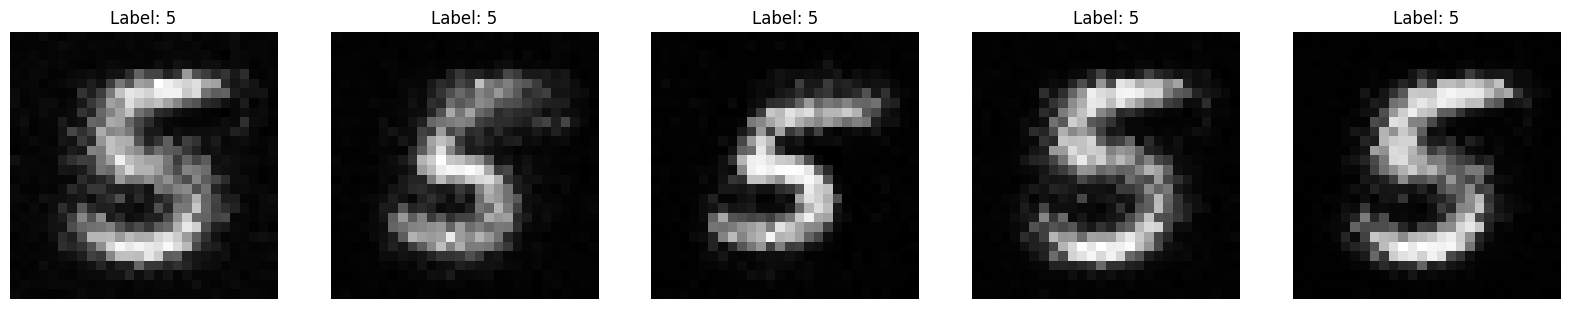

Epoch [11/20], d_loss: 0.7038, g_loss: 1.6860


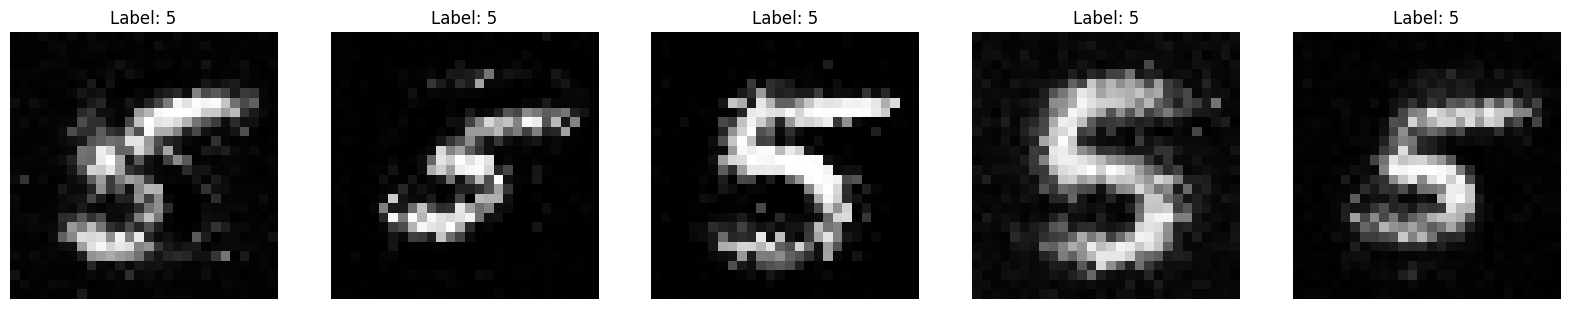

Epoch [12/20], d_loss: 1.0508, g_loss: 1.8067


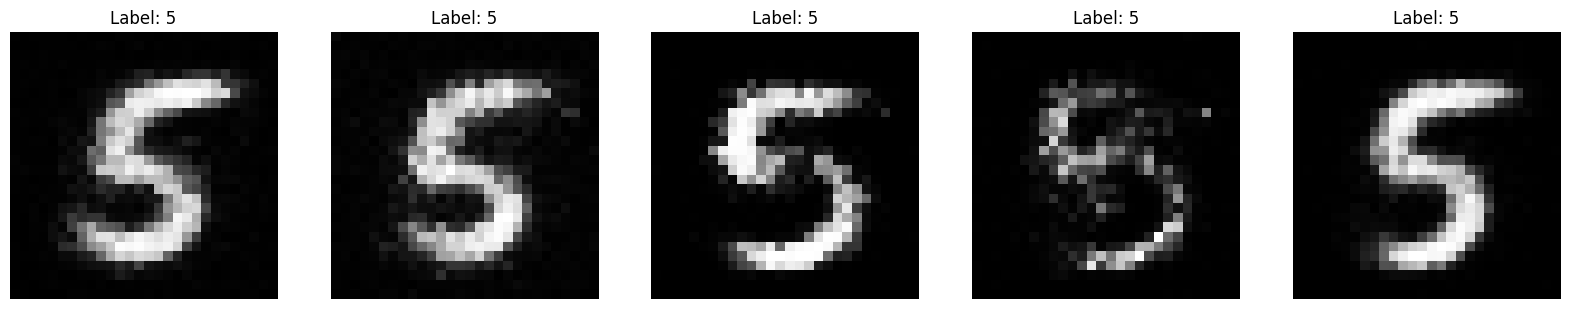

Epoch [13/20], d_loss: 1.3466, g_loss: 1.0988


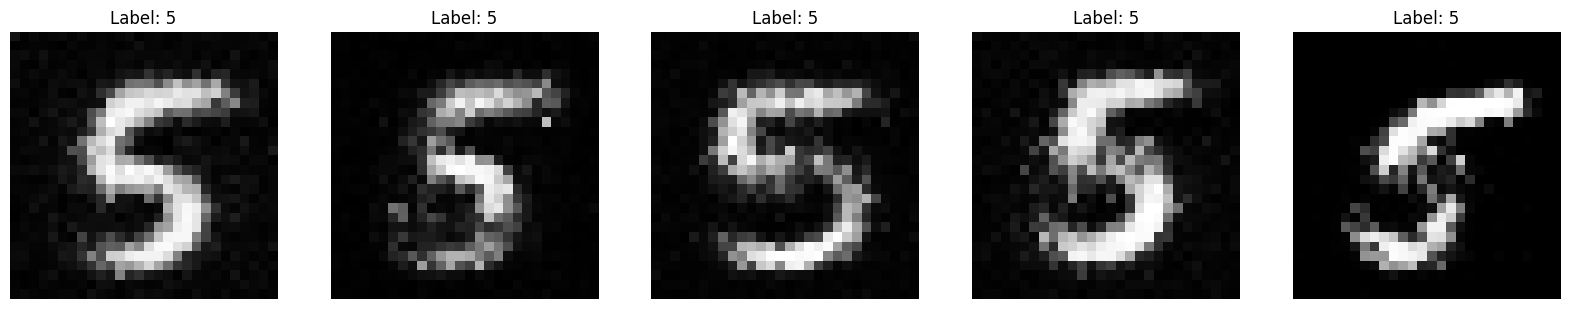

Epoch [14/20], d_loss: 1.0567, g_loss: 1.3024


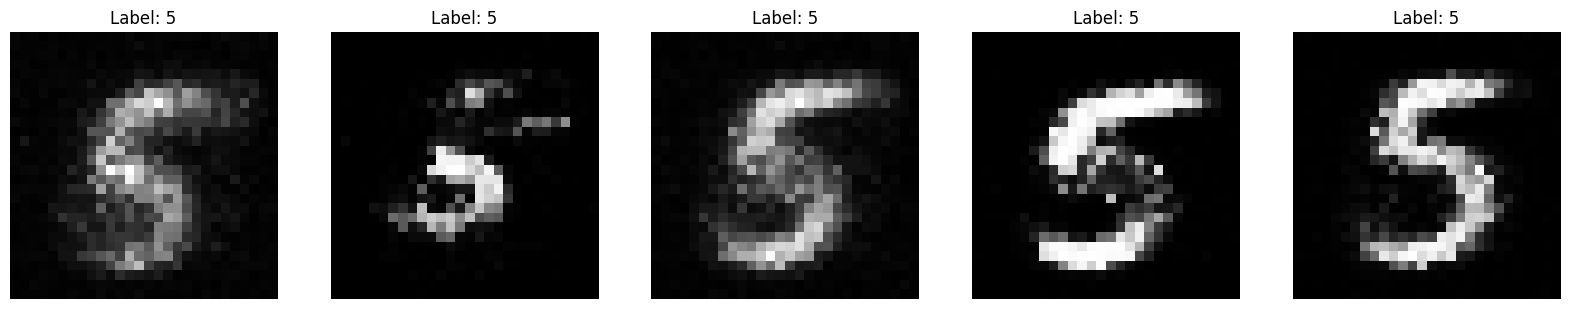

Epoch [15/20], d_loss: 1.0461, g_loss: 1.4169


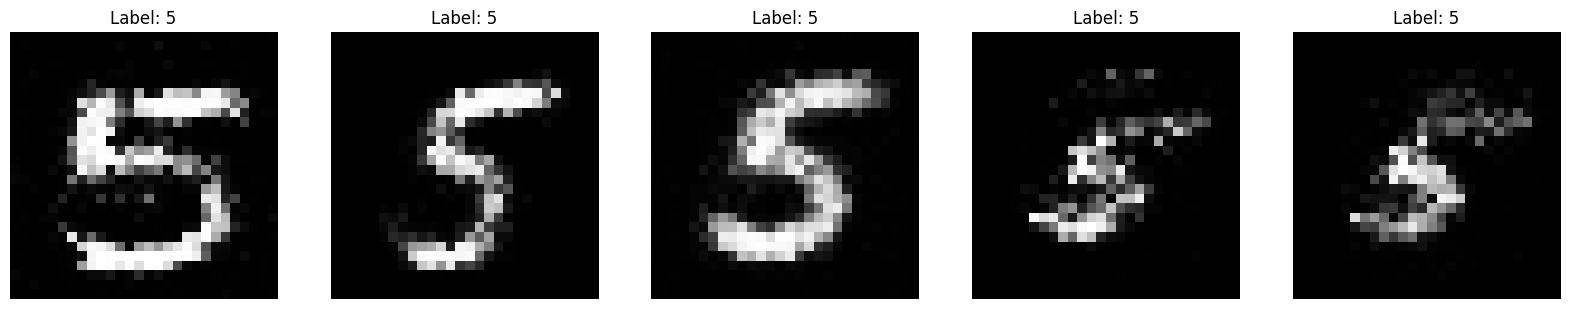

Epoch [16/20], d_loss: 0.9977, g_loss: 1.5905


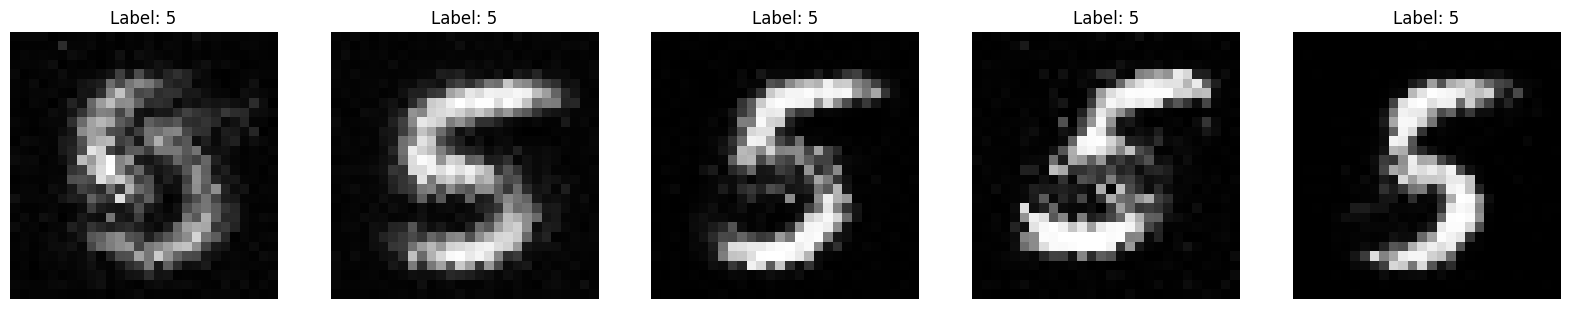

Epoch [17/20], d_loss: 0.7229, g_loss: 1.9202


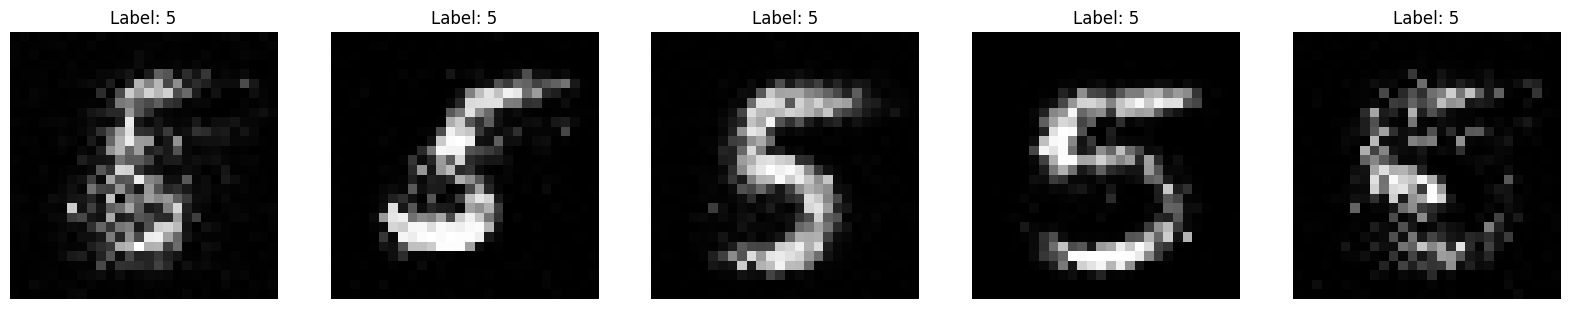

Epoch [18/20], d_loss: 0.6944, g_loss: 1.6808


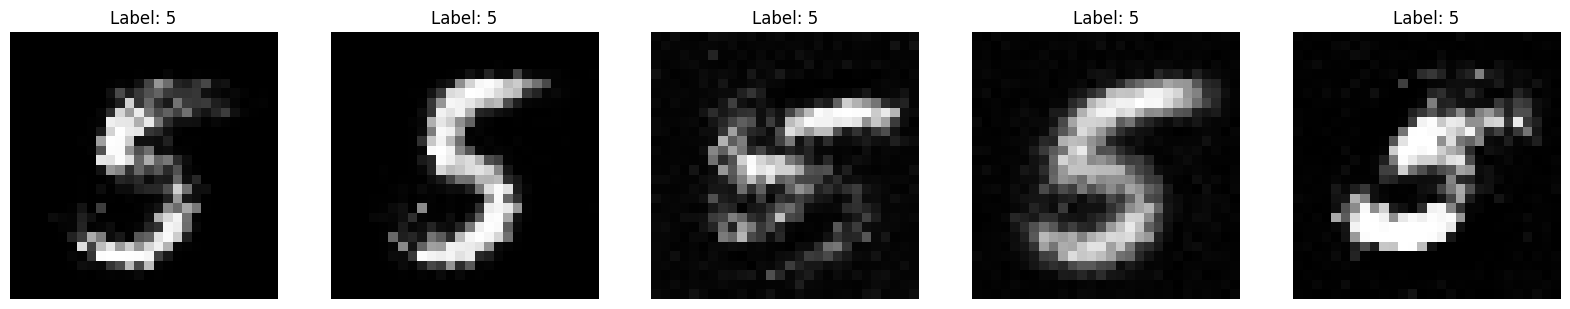

Epoch [19/20], d_loss: 0.8685, g_loss: 1.9978


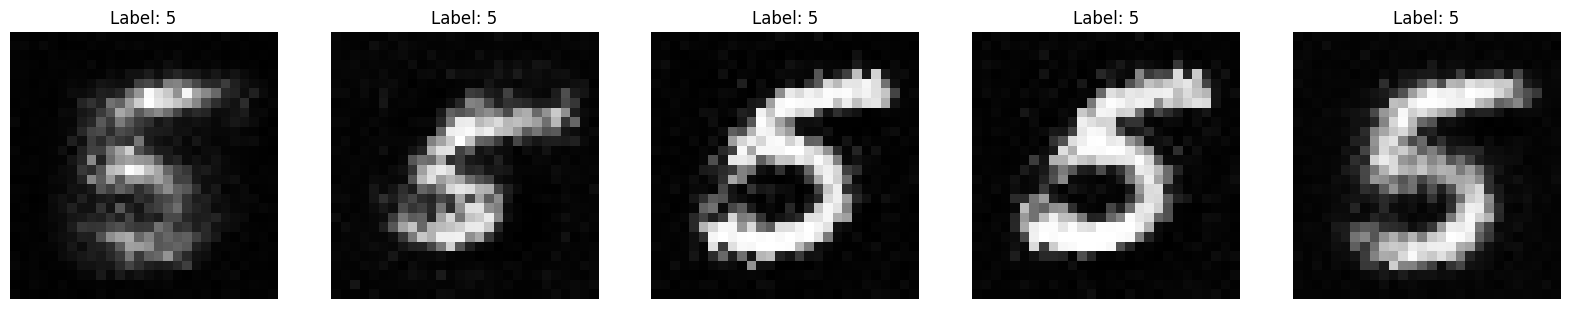

Epoch [20/20], d_loss: 0.7786, g_loss: 1.3346


In [45]:
train = True

if train:
    plt.close()
    num_epochs = 20
    for epoch in range(num_epochs):
        for batch_idx, (real_images, real_labels) in enumerate(train_loader):
            batch_size = real_images.size(0)

            # Train Discriminator
            real_labels_one_hot = torch.ones(batch_size, 1)
            fake_labels_one_hot = torch.zeros(batch_size, 1)

            real_images = real_images.to(torch.float32)
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels_one_hot)

            # Sample noise and random class labels
            z = torch.randn(batch_size, NUM_INPUT_CLASSES*NOISE_SIZE)
            random_labels = torch.randint(0, NUM_INPUT_CLASSES, (batch_size,))  # Random labels between 0-9

            # Generate fake images conditioned on the random labels
            fake_images = generator(z, random_labels)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels_one_hot)

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels_one_hot)  # We want the fake images to be classified as real

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

        # DIsplay at the end of every epoch

        class_labels = torch.randint(5, 6, (5,))  # Specific class labels
        z = torch.randn(len(class_labels), NUM_INPUT_CLASSES*NOISE_SIZE)  # 16 random noise vectors
        fake_images = generator(z, class_labels)

        fake_images = fake_images.detach().numpy()
        fig, axes = plt.subplots(1, len(class_labels), figsize=(20, 5))

        for i in range(len(class_labels)):
            ax = axes[i]
            ax.imshow(fake_images[i].reshape(28, 28), cmap='gray')
            ax.set_title(f'Label: {class_labels[i].item()}')
            ax.axis('off')
        plt.show()

        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

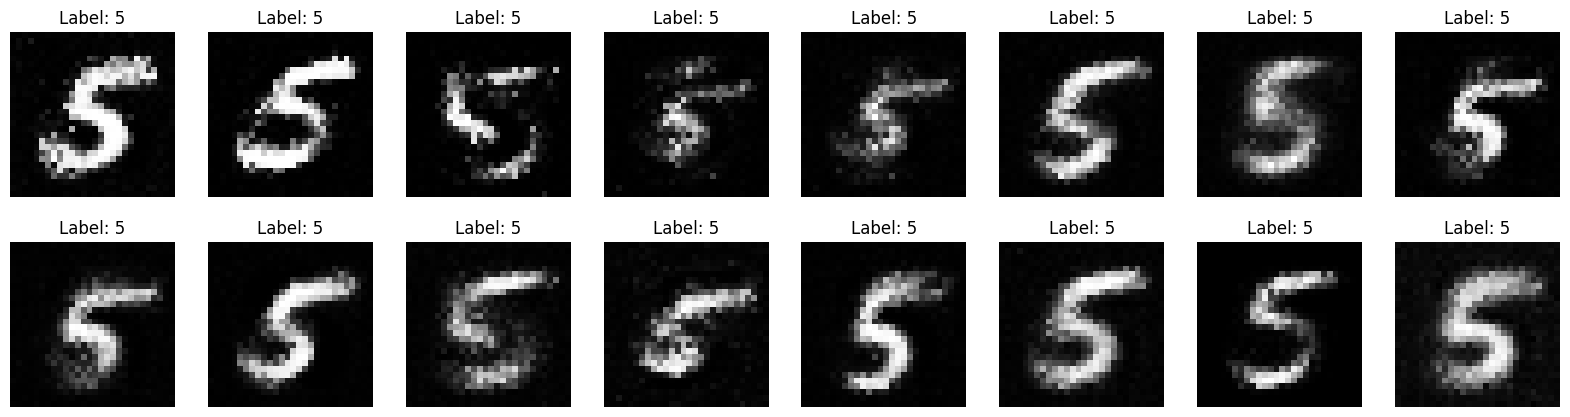

In [46]:
z = torch.randn(16, NUM_INPUT_CLASSES*NOISE_SIZE)  # 16 random noise vectors
class_labels = torch.randint(5, 6, (16,))  # Specific class labels
fake_images = generator(z, class_labels)

fake_images = fake_images.detach().numpy()
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for i in range(16):
    ax = axes[i//8, i%8]
    ax.imshow(fake_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {class_labels[i].item()}')
    ax.axis('off')
plt.show()